Instalacion de emojis para poder visualizarlas

In [221]:
#!pip install emoji

Librearias necesarias

In [222]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import re
import requests
from io import StringIO
import regex
import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

Ejcucion de Google Drive

In [223]:
# URL del archivo en GitHub
url = 'https://raw.githubusercontent.com/LexoBrunett/WhatsApp_Chat_Analysis/main/Data/phone_patterns.txt'

# Obtener el contenido del archivo desde la URL
response = requests.get(url)
if response.status_code == 200:
    # Obtener los patrones de los números telefónicos de países
    phone_patterns = [line.strip().split(';') for line in response.text.split('\n') if line.strip()]

    # Filtrar líneas que no tienen el formato esperado
    phone_patterns = [pattern[1] + ":" for pattern in phone_patterns if len(pattern) > 1]

    print(phone_patterns)
else:
    print(f"No se pudo obtener el archivo. Código de estado: {response.status_code}")


['([+]\\d{2} \\d{3} \\d{3} \\d{3}):', '([+]\\d{2} \\d{1} \\d{2} \\d{4}-\\d{4}):', '([+]\\d{2} \\d{1} \\d{3} \\d{3}-\\d{4}):', '([+]\\d{2} \\d{1} \\d{4} \\d{2}-\\d{4}):', '([+]\\d{2} \\d{2} \\d{4} \\d{4}):', '([+]\\d{2} \\d{3} \\d{3} \\d{4}):', '([+]\\d{2} \\d{2} \\d{5}-\\d{4}):', '([+]\\d{2} \\d{1} \\d{4} \\d{4}):', '([+]\\d{2} \\d{3} \\d{7}):', '([+]\\d{3} \\d{2} \\d{3} \\d{4}):', '([+]\\d{2} \\d{3}-\\d{7}):', '([+]\\d{3} \\d{8}):', '([+]\\d{3} \\d{2} \\d{3} \\d{3}):', '([+]\\d{2} \\d{3} \\d{2} \\d{2} \\d{2}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{1} \\(\\d{3}\\) \\d{3}-\\d{4}):', '([+]\\d{3} \\d{3}-\\d{4}):', '([+]\\d{3} \\d{4}-\\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{3} \\d{4} \\d{4}):', '([+]\\d{1} \

Funciones para el problema

In [224]:
# Patron regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    patron = '^(\d{1,2})/(\d{1,2})/(\d{4}), (\d{1,2}):(\d{2}) -'
    #patron = '^([1-9]|1[0-2])(\/)([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)(2[0-9]), ([0-9]+):([0-9][0-9])\s?([AP][M]) -'
    resultado = re.match(patron, s)
    return resultado is not None
    #if resultado:
        #print(f"Línea '{s}' coincide con el patrón de fecha y hora.")
        #return True
    #print(f"Línea '{s}' NO coincide con el patrón de fecha y hora.")
    #return False

# Patrón para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = [
        '([\w]+):',                                # Nombre
        '([\w]+[\s]+[\w]+):',                      # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',            # Nombre 1 + Nombre 2 + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+):',  # Nombre 1 + Nombre 2+ Nombre 3 + Apellido
        '([\w]+[\s])[\u263a-\U0001f999]+:',        # Nombre + Emoji
        "(\b\w+\b\s+){4}[\u263a-\U0001f999]+[\u263a-\U0001f999]+:", # Nombre 1 + Nombre 2+ Nombre 3 + Apellido + Emoji + Emoji

    ]
    patrones+=phone_patterns # Se añade los patrones de los números telefónicos

    patron = '^' + '|'.join(patrones)
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    splitLinea = linea.split(' - ')
    FechaHora = splitLinea[0]
    splitFechaHora = FechaHora.split(', ')
    Fecha = splitFechaHora[0]
    Hora = ' '.join(splitFechaHora[1:])
    Mensaje = ' '.join(splitLinea[1:])
    if EncontrarMiembro(Mensaje):
        splitMensaje = Mensaje.split(': ')
        Miembro = splitMensaje[0]
        Mensaje = ' '.join(splitMensaje[1:])
    else:
        Miembro = None
    #print(f"Línea '{linea}' se dividió en Fecha='{Fecha}', Hora='{Hora}', Miembro='{Miembro}', Mensaje='{Mensaje}'.")
    return Fecha, Hora, Miembro, Mensaje


Usar chat en txt exportado para transformarlo en Dataframe

In [225]:
# URL del archivo en GitHub
url = 'https://raw.githubusercontent.com/LexoBrunett/WhatsApp_Chat_Analysis/main/Data/ChatConMiAmorchi.txt'

# Obtener el contenido del archivo desde el URL
response = requests.get(url)
content = response.text

# Utilizar StringIO para leer el contenido como un archivo
fp = StringIO(content)

#print(content)
# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
# Guardar el contenido en un archivo local con un nombre más corto
local_filename = 'ChatConMiAmorchi.txt'
with open(local_filename, 'w', encoding='utf-8') as local_file:
    local_file.write(content)

# Utilizar StringIO para leer el contenido como un archivo
with open(local_filename, encoding="utf-8") as fp:

    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    Fecha, Hora, Miembro = None, None, None
    while True:
      linea = fp.readline()
      if not linea:
        break
      linea = linea.strip()
      if IniciaConFechaYHora(linea):
        Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea)
        DatosLista.append([Fecha, Hora, Miembro, Mensaje])
      else:
        #print(f"Línea '{linea}' NO coincide con el patrón de fecha y hora. Se omitirá.")
        continue  # Saltar al siguiente ciclo del bucle


# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%Y", errors='coerce')

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Resetear el índice
df.reset_index(drop=True, inplace=True)

# Imprimir el dataframe
df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,# Mensajes
0,2023-08-19,21:16,Emily,Era otra regla,[],0,1
1,2023-08-19,21:16,Emily,Trabajar con la totalidad de datos,[],0,1
2,2023-08-19,21:16,Emily,Creo que tocará comprar 17 vs 3k,[],0,1
3,2023-08-19,21:19,Lexo,Ya beo,[],0,1
4,2023-08-19,21:19,Lexo,Bueno es lo q tienen,[],0,1
...,...,...,...,...,...,...,...
39993,2023-12-03,11:59,Lexo,Oki mi amororo,[],0,1
39994,2023-12-03,11:59,Lexo,Te amo,[],0,1
39995,2023-12-03,11:59,Lexo,Q talll,[],0,1
39996,2023-12-03,11:59,Lexo,:3,[],0,1


Estadisticas de Mensajes, Multimedia, Etc.

In [226]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje) # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if caracter in emoji.EMOJI_DATA: # Obtener emojis en idioma español
            emoji_lista.append(caracter)
    return emoji_lista
# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: re.findall(url_patron, x)).str.len() # Se agrega columna 'URLs'
links = np.sum(df.URLs)

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,39998
Multimedia,1847
Emojis,229
Links,130


Dataframes con identificacion de Emojis y URLs

In [227]:
# Dataframe principal con las columnas 'Emojis' y 'URLs' agregadas
df.tail(10)

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,# Mensajes
39988,2023-12-03,11:41,Emily,Jajaja es que siempre los veía en 200,[],0,1
39989,2023-12-03,11:41,Emily,Lo compre diferido jaja,[],0,1
39990,2023-12-03,11:42,Emily,A $5 por 3 meses,[],0,1
39991,2023-12-03,11:42,Emily,UwU,[],0,1
39992,2023-12-03,11:59,Lexo,Enserio,[],0,1
39993,2023-12-03,11:59,Lexo,Oki mi amororo,[],0,1
39994,2023-12-03,11:59,Lexo,Te amo,[],0,1
39995,2023-12-03,11:59,Lexo,Q talll,[],0,1
39996,2023-12-03,11:59,Lexo,:3,[],0,1
39997,2023-12-03,11:59,Lexo,Emifoto?,[],0,1


Emojis mas Usados

In [228]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df.head(10)

Número emojis únicos usados:  30 



,Cantidad
Emoji,
🦃,36
🥟,34
🚜,22
🤑,20
🚁,19
🙏,16
❤️,13
🍀,10
😍,8


In [229]:
# Crear una nueva columna 'Emojis' que contiene la lista de emojis en cada mensaje
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis)

# Obtener la cantidad de emojis enviados por cada miembro
emojis_por_miembro = df.groupby('Miembro')['Emojis'].apply(lambda x: sum(x.str.len())).reset_index(name='Emojis')

# Mostrar la cantidad de emojis por miembro
print(emojis_por_miembro)

emojis_por_miembro_sorted = emojis_por_miembro.sort_values(by='Emojis', ascending=True)

# Mostrar el DataFrame ordenado por cantidad de emojis de forma ascendente
print(emojis_por_miembro_sorted)

  Miembro  Emojis
0   Emily      10
1    Lexo     219
  Miembro  Emojis
0   Emily      10
1    Lexo     219


In [230]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Cuando agregamos archivos Jupyter Notebook o IPython Notebook con una extensión .ipynb en GitHub
# se mostrarán como archivos HTML estáticos en su repositorio, pero los gráficos de trazado son interactivos

In [231]:
# Identificar a todos los miembros del grupo
df.Miembro.unique()

array(['Emily', 'Lexo'], dtype=object)

In [232]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,# Mensajes,Letras,Palabras
39993,2023-12-03,11:59,Lexo,Oki mi amororo,[],0,1,14,3
39994,2023-12-03,11:59,Lexo,Te amo,[],0,1,6,2
39995,2023-12-03,11:59,Lexo,Q talll,[],0,1,7,2
39996,2023-12-03,11:59,Lexo,:3,[],0,1,2,1
39997,2023-12-03,11:59,Lexo,Emifoto?,[],0,1,8,1


In [233]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
  lista = []
  # Filtrar mensajes de un miembro en específico
  miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

  # Agregar a la lista el número total de mensajes enviados
  lista.append(miembro_df.shape[0])

  # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
  palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
  lista.append(palabras_por_msj )

  # Agregar a la lista el número de mensajes multimedia enviados
  multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
  lista.append(multimedia)

  # Agregar a la lista el número total de emojis enviados
  emojis = sum(miembro_df['Emojis'].str.len())
  lista.append(emojis)

  # Agregar a la lista el número total de links enviados
  links = sum(miembro_df['URLs'])
  lista.append(links)

  # Asignar la lista como valor a la llave del diccionario
  dictionario[miembros[i]] = lista
print(dictionario)

{'Emily': [16190, 4.565596046942557, 902, 10, 27], 'Lexo': [21961, 3.2870087883065433, 945, 219, 103]}


In [234]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df.head(10)

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Emily,16190,4.565596,902,10,27
Lexo,21961,3.287009,945,219,103


Text(0, 0.5, 'Fecha')

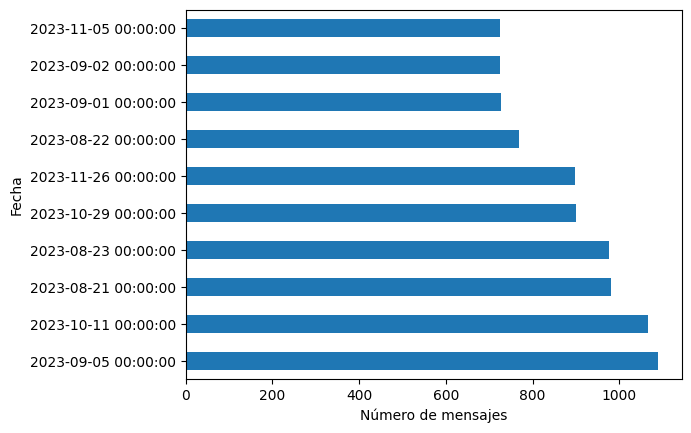

In [235]:
# Determinar los días más activos del grupo
df['Fecha'].value_counts().head(10).plot.barh() # Plotear 10 días
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

Text(0, 0.5, 'Fecha')

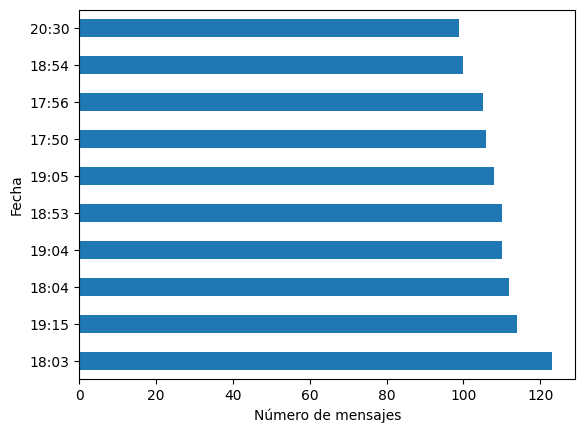

In [236]:
# Determinar las horas en las que el grupo está más activo
df['Hora'].value_counts().head(10).plot.barh()
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

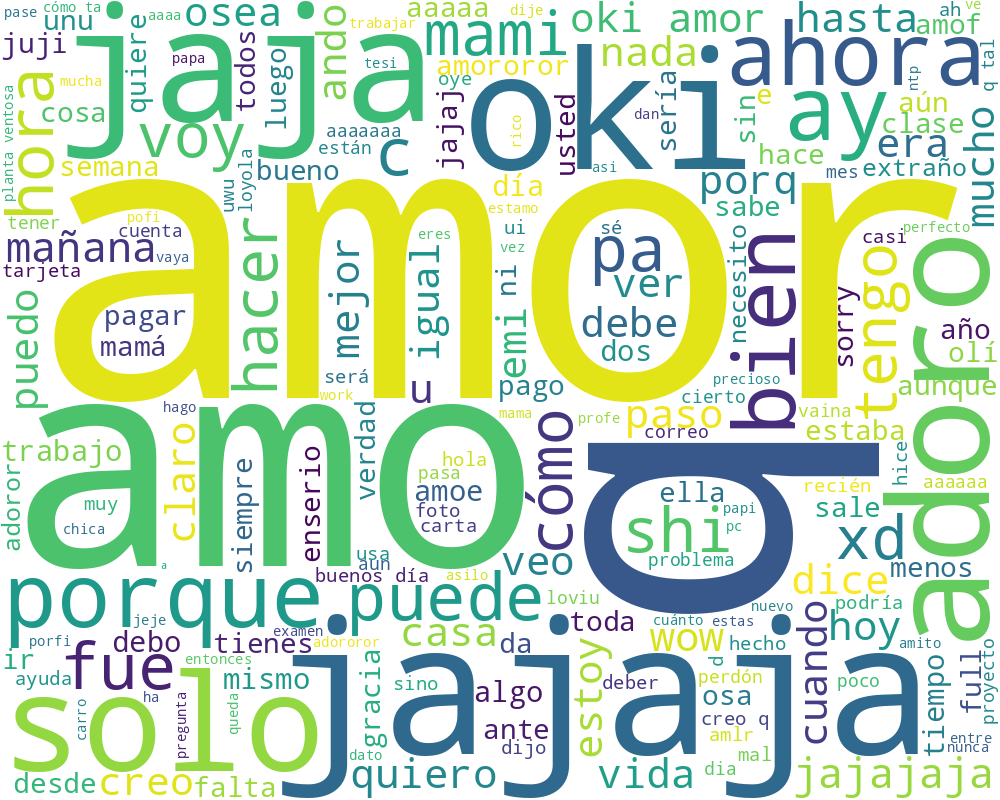

In [219]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta',
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han'])

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
  palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
  for palabra in palabras:
    total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()

In [220]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(
        size=17))
fig.update_xaxes(nticks=20)
fig.show()

# Cuando agregamos archivos Jupyter Notebook o IPython Notebook con una extensión .ipynb en GitHub
# se mostrarán como archivos HTML estáticos en su repositorio, pero los gráficos de trazado son interacti

<ipython-input-220-97952c2ec7ce>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

